In [202]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from scipy.spatial.distance import pdist, squareform
import community as community_louvain
from networkx.algorithms import community
import igraph as ig
from igraph import Graph, plot
import networkx as nx
import cairocffi
import igraph
#from igraph import *
import random
from scipy import stats
from scipy.stats import pearsonr, spearmanr
from scipy.cluster.hierarchy import linkage, dendrogram
from matplotlib.lines import Line2D
from PIL import Image

Load data

In [203]:
# otu table
ecdata = pd.read_csv("otu.csv", index_col="EC")
ecdata = ecdata.drop(columns=["prt_read_lenght_av"])

# pathways table
pathways_df = pd.read_csv('Carbon_EC_numbers - Pathways_overlap.csv')
ec_c_fixation_df = pathways_df[pathways_df['pathway'].isin(['3HBC', 'CBB', 'DCHB', 'HPHB', 'rTCA', 'WL'])]
ec_list = pathways_df.EC.values.flatten() #List of all C related ECs
ec_c_fixation_list = ec_c_fixation_df.EC.values.flatten() #List of C-fixation related ECs



#ADDED on 20241010: i joint the otu from Fullerton
ecdata_fullerton = pd.read_csv("mifaser_dataset_from_Fullerton.csv", index_col="EC").drop(ecdata_fullerton.columns[0], axis=1)
merged_df = pd.concat([ecdata, ecdata_fullerton], axis=1, join='outer')
ecdata = merged_df

Prevalence analysis (first with sum of abundance / second with mean abundance)

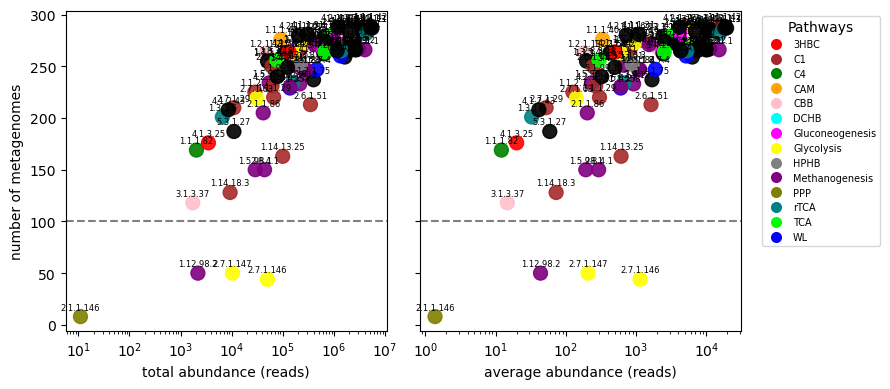

In [204]:
tested_df = ecdata.loc[ecdata.index.isin(ec_list)]

# Calculate prevalence
prevalence = (tested_df > 0).sum(axis=1)

# Calculate average and sum of abundances
filtered_ecdata = tested_df[tested_df > 0]
average_abundance = filtered_ecdata.sum(axis=1) / filtered_ecdata.count(axis=1)
sum_abundance = filtered_ecdata.sum(axis=1)

# Define a specific color for each pathway
pathway_colors = {
    '3HBC': 'red',
    'C1': 'brown',
    'C4': 'green',
    'CAM': 'orange',
    'CBB': 'pink',
    'DCHB': 'cyan',
    'Gluconeogenesis': 'magenta',
    'Glycolysis': 'yellow',
    'HPHB': 'gray',
    'Methanogenesis': 'purple',
    'PPP': 'olive',
    'rTCA': 'teal',
    'TCA': 'lime',
    'WL': 'blue'
}

# Create a dictionary to map EC numbers to colors
ec_to_pathway = pathways_df.groupby('EC')['pathway'].apply(lambda x: '/'.join(x))
ec_to_color = {ec: 'black' if len(pathways.split('/')) > 1 else pathway_colors.get(pathways.split('/')[0], 'black')
               for ec, pathways in ec_to_pathway.items()}

# Map EC numbers to colors
colors = [ec_to_color.get(ec, 'black') for ec in tested_df.index]

# Create the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

# Plot 1: Average abundance
scatter1 = ax1.scatter(sum_abundance, prevalence, c=colors, alpha=.9, s=100)
ax1.axhline(y=100, color='gray', linestyle='--')
ax1.set_xlabel('total abundance (reads)')
ax1.set_xscale('log')
ax1.set_ylabel('number of metagenomes')

# Plot 2: Sum of abundances
scatter2 = ax2.scatter(average_abundance, prevalence, c=colors, alpha=.9, s=100)
ax2.axhline(y=100, color='gray', linestyle='--')
ax2.set_xlabel('average abundance (reads)')
ax2.set_xscale('log')
ax2.set_yticklabels([])
#ax2.set_ylabel('number of metagenomes')

# Add legend to the second plot
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=9, linestyle='') 
           for color in pathway_colors.values()]
ax2.legend(handles, pathway_colors.keys(), title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7)

# Annotate dots with EC numbers on both plots
for i, (x, y, ec) in enumerate(zip(sum_abundance, prevalence, tested_df.index)):
    ax1.annotate(ec, (x, y), textcoords="offset points", xytext=(0,5), ha='center', fontsize=6)

for i, (x, y, ec) in enumerate(zip(average_abundance, prevalence, tested_df.index)):
    ax2.annotate(ec, (x, y), textcoords="offset points", xytext=(0,5), ha='center', fontsize=6)

plt.tight_layout()
plt.show()

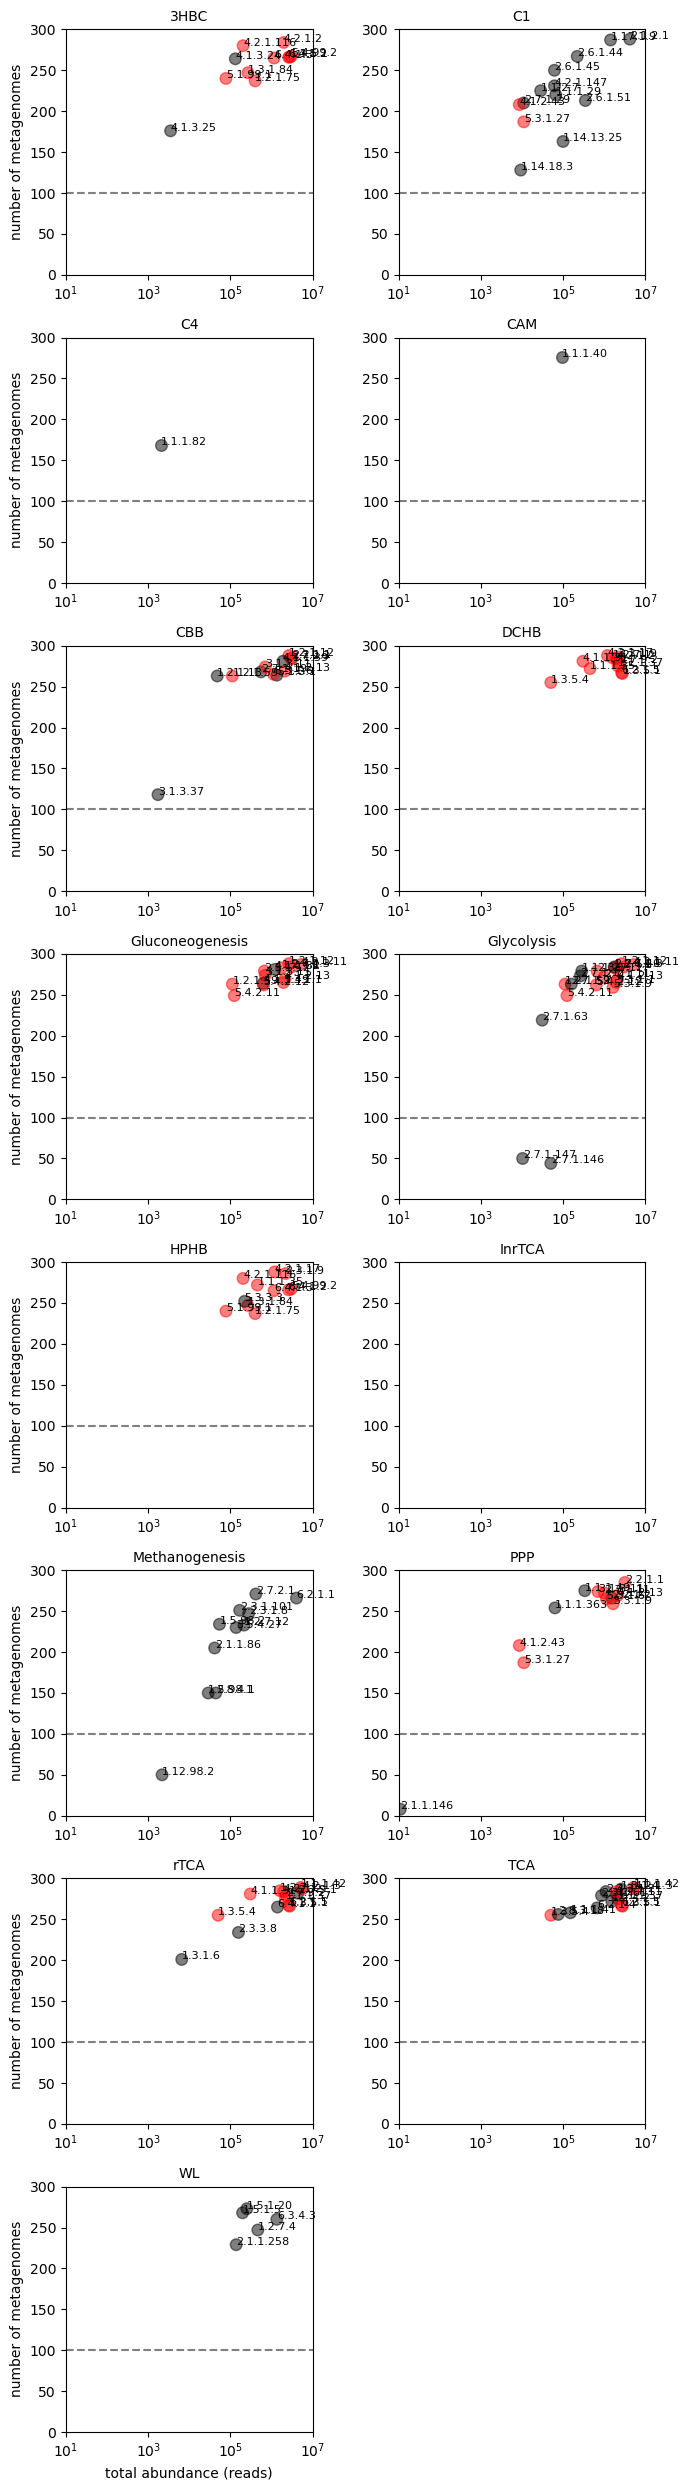

In [205]:
# Merge ecdata with pathways_df based on EC numbers
merged_df = pd.merge(pathways_df, ecdata, left_on='EC', right_index=True, how='right')

# Group by pathways
grouped_pathways = merged_df.groupby('pathway')

# Check if any EC is in more than one pathway
ec_in_multiple_pathways = pathways_df.groupby('EC').filter(lambda x: len(x) > 1)['EC'].unique()

fig, axes = plt.subplots(8, 2, figsize=(7, 25)) 
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Get all pathways
all_pathways = pathways_df['pathway'].unique()

# Loop through each pathway (including empty pathways) and create the plot
for idx, (ax, pathway) in enumerate(zip(axes, all_pathways)):
    if pathway in grouped_pathways.groups:
        group = grouped_pathways.get_group(pathway)

        # Drop 'pathway' and 'EC' columns to get only abundance data
        abundance_data = group.drop(columns=['pathway', 'EC'])

        # Ensure only numeric columns are selected (abundance data should be numeric)
        abundance_data = abundance_data.apply(pd.to_numeric, errors='coerce')

        # Calculate the prevalence (number of metagenomes where abundance > 0) for each EC number
        prevalence = (abundance_data > 0).sum(axis=1)

        # Calculate the total abundance for each EC number
        total_abundance = abundance_data.sum(axis=1)

        # Plotting with special color for EC numbers in multiple pathways
        colors = ['red' if ec in ec_in_multiple_pathways else 'black' for ec in group['EC']]
        ax.scatter(total_abundance, prevalence, color=colors, alpha=0.5, s=70)

        ax.axhline(y=100, color='gray', linestyle='--')

        # Add EC numbers as text labels next to each point
        for i, ec_number in enumerate(group['EC']):
            ax.text(total_abundance.iloc[i], prevalence.iloc[i], ec_number, fontsize=8)

    ax.set_title(f'{pathway}', fontsize=10)
    ax.grid(False)
    ax.set_xscale('log')
    ax.set_xlim(10, 10**7)
    ax.set_ylim(0, 300)

    # Set labels for only the outermost plots
    if idx % 2 == 0:  # First column
        ax.set_ylabel('number of metagenomes')
    if idx >= 14:  # Last row
        ax.set_xlabel('total abundance (reads)')

# Add empty plots if needed for pathways without EC numbers in the OTU table
for i in range(len(all_pathways), len(axes)):
    axes[i].axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()
#plt.savefig('prevalence_anal_total.png', dpi=300)

plt.show()


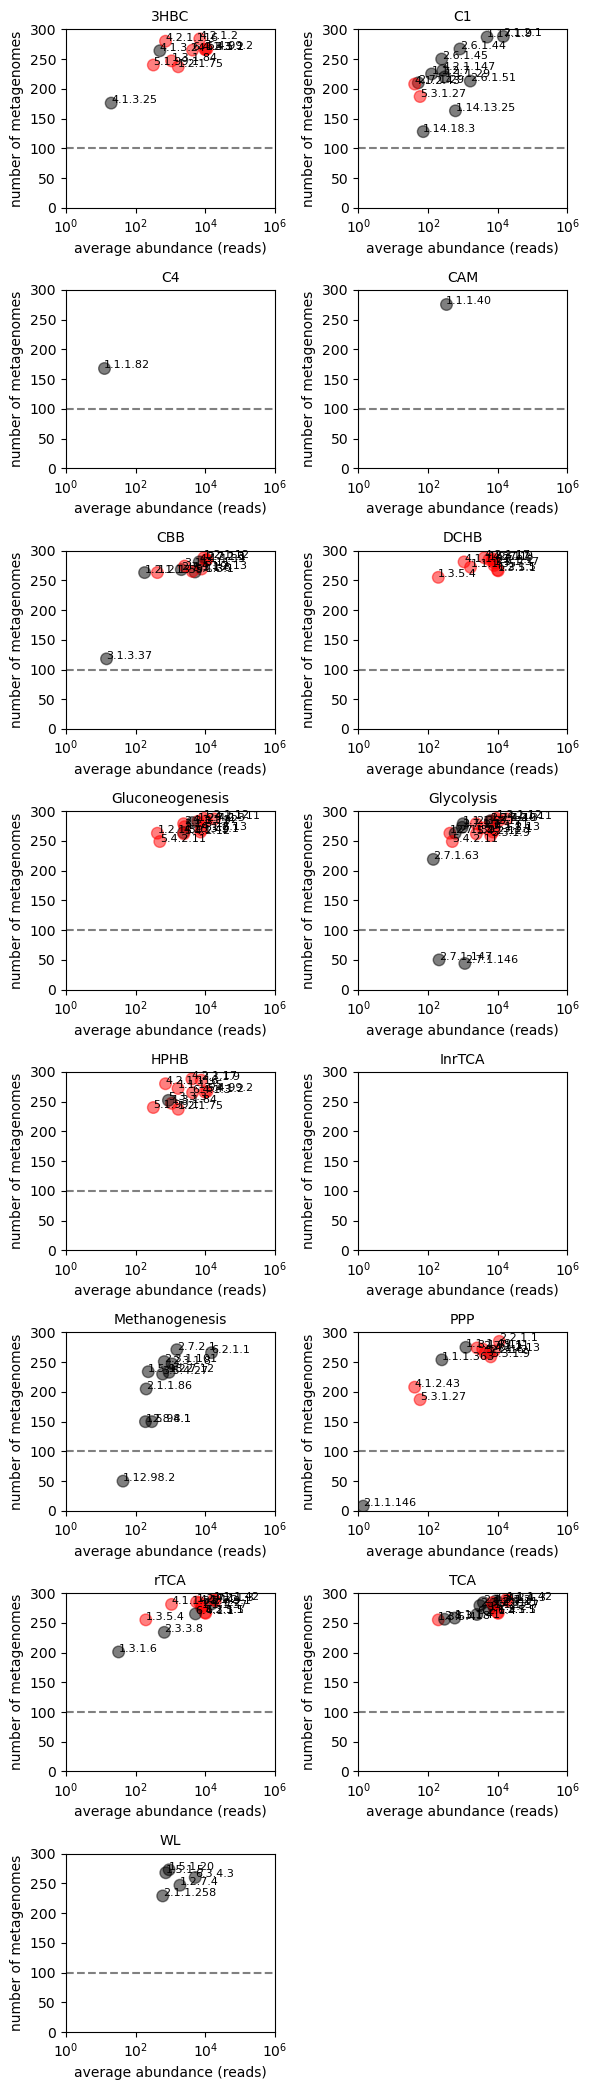

In [9]:
# Merge ecdata with pathways_df based on EC numbers
merged_df = pd.merge(pathways_df, ecdata, left_on='EC', right_index=True, how='right')

# Group by pathways
grouped_pathways = merged_df.groupby('pathway')

# Check if any EC is in more than one pathway
ec_in_multiple_pathways = pathways_df.groupby('EC').filter(lambda x: len(x) > 1)['EC'].unique()

# Set up a 7x2 grid for the subplots
fig, axes = plt.subplots(8, 2, figsize=(6, 21))  # 7 rows, 2 columns
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Get all pathways
all_pathways = pathways_df['pathway'].unique()

# Loop through each pathway (including empty pathways) and create the plot
for ax, pathway in zip(axes, all_pathways):
    if pathway in grouped_pathways.groups:
        group = grouped_pathways.get_group(pathway)

        # Drop 'pathway' and 'EC' columns to get only abundance data
        abundance_data = group.drop(columns=['pathway', 'EC'])

        # Ensure only numeric columns are selected (abundance data should be numeric)
        abundance_data = abundance_data.apply(pd.to_numeric, errors='coerce')

        # Calculate the prevalence (number of metagenomes where abundance > 0) for each EC number
        prevalence = (abundance_data > 0).sum(axis=1)

        # Calculate the total abundance for each EC number
        total_abundance = abundance_data.mean(axis=1)

        # Plotting with special color for EC numbers in multiple pathways
        colors = ['red' if ec in ec_in_multiple_pathways else 'black' for ec in group['EC']]
        ax.scatter(total_abundance, prevalence, color=colors, alpha = .5, s=70)

        ax.axhline(y=100, color='gray', linestyle='--')

        # Add EC numbers as text labels next to each point
        for i, ec_number in enumerate(group['EC']):
            ax.text(total_abundance.iloc[i], prevalence.iloc[i], ec_number, fontsize=8)

    ax.set_title(f'{pathway}', fontsize=10)
    ax.grid(False)
    ax.set_xscale('log')
    ax.set_xlim(1, 10**6)
    ax.set_ylim(0, 300)

    # Set labels for only the outermost plots
    if idx % 2 == 0:  # First column
        ax.set_ylabel('number of metagenomes')
    if idx >= 14:  # Last row
        ax.set_xlabel('average abundance (reads)')

# Add empty plots if needed for pathways without EC numbers in the OTU table
for i in range(len(all_pathways), len(axes)):
    axes[i].axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()
#plt.savefig('prevalence_anal_avg.png', dpi=300)

plt.show()


Clean dataset

In [206]:
#Identified by Deborah
ecdata = ecdata.drop(ecdata.columns[[124, 122, 148, 152, 150, 139, 140, 141, 142, 143, 144, 153, 137, 138, 133, 134, 64, 76, 72, 77, 174, 175, 198, 176, 173, 232, 233, 231, 69, 67, 76, 71]], axis=1)

#Identified by me
ecdata = ecdata.drop(columns=['SAMN10130915']) #weird metagenome: Contains only a few EC

Repeat prevalence analysis

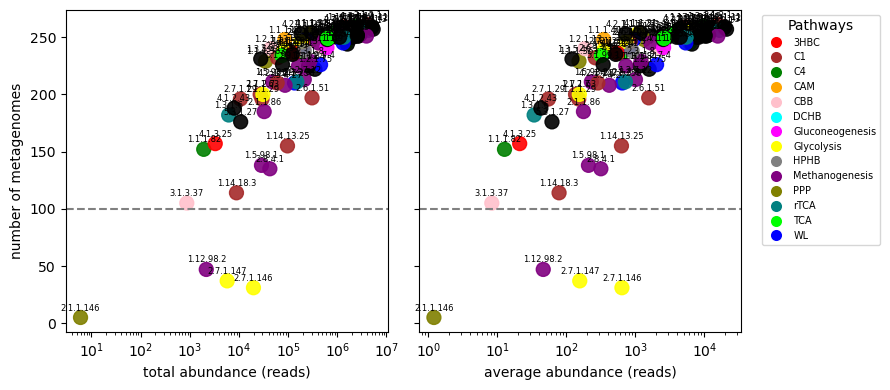

In [207]:
tested_df = ecdata.loc[ecdata.index.isin(ec_list)]

# Calculate prevalence
prevalence = (tested_df > 0).sum(axis=1)

# Calculate average and sum of abundances
filtered_ecdata = tested_df[tested_df > 0]
average_abundance = filtered_ecdata.sum(axis=1) / filtered_ecdata.count(axis=1)
sum_abundance = filtered_ecdata.sum(axis=1)

# Define a specific color for each pathway
pathway_colors = {
    '3HBC': 'red',
    'C1': 'brown',
    'C4': 'green',
    'CAM': 'orange',
    'CBB': 'pink',
    'DCHB': 'cyan',
    'Gluconeogenesis': 'magenta',
    'Glycolysis': 'yellow',
    'HPHB': 'gray',
    'Methanogenesis': 'purple',
    'PPP': 'olive',
    'rTCA': 'teal',
    'TCA': 'lime',
    'WL': 'blue'
}

# Create a dictionary to map EC numbers to colors
ec_to_pathway = pathways_df.groupby('EC')['pathway'].apply(lambda x: '/'.join(x))
ec_to_color = {ec: 'black' if len(pathways.split('/')) > 1 else pathway_colors.get(pathways.split('/')[0], 'black')
               for ec, pathways in ec_to_pathway.items()}

# Map EC numbers to colors
colors = [ec_to_color.get(ec, 'black') for ec in tested_df.index]

# Create the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

# Plot 1: Average abundance
scatter1 = ax1.scatter(sum_abundance, prevalence, c=colors, alpha=.9, s=100)
ax1.axhline(y=100, color='gray', linestyle='--')
ax1.set_xlabel('total abundance (reads)')
ax1.set_xscale('log')
ax1.set_ylabel('number of metagenomes')

# Plot 2: Sum of abundances
scatter2 = ax2.scatter(average_abundance, prevalence, c=colors, alpha=.9, s=100)
ax2.axhline(y=100, color='gray', linestyle='--')
ax2.set_xlabel('average abundance (reads)')
ax2.set_xscale('log')
ax2.set_yticklabels([])
#ax2.set_ylabel('number of metagenomes')

# Add legend to the second plot
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=9, linestyle='') 
           for color in pathway_colors.values()]
ax2.legend(handles, pathway_colors.keys(), title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7)

# Annotate dots with EC numbers on both plots
for i, (x, y, ec) in enumerate(zip(sum_abundance, prevalence, tested_df.index)):
    ax1.annotate(ec, (x, y), textcoords="offset points", xytext=(0,5), ha='center', fontsize=6)

for i, (x, y, ec) in enumerate(zip(average_abundance, prevalence, tested_df.index)):
    ax2.annotate(ec, (x, y), textcoords="offset points", xytext=(0,5), ha='center', fontsize=6)


plt.tight_layout()
plt.show()


In [208]:
#fill NaN values with 0
ecdata = ecdata.fillna(0)


In [209]:
ecdata

CR18BCF  BQ170218F  BQ170218S  BQ170218  BR170218_2F  BR170218_1  \
EC                                                                            
1.1.1.1     1175.0     8191.0     8848.0    7199.0       4631.0      1511.0   
1.1.1.10      17.0        0.0        0.0       0.0          6.0         9.0   
1.1.1.100   6054.0     4291.0     5304.0    3802.0      10787.0     11054.0   
1.1.1.103   1660.0       30.0      669.0      36.0       1607.0      1962.0   
1.1.1.107     52.0      144.0      136.0     209.0         42.0       104.0   
...            ...        ...        ...       ...          ...         ...   
7.5.2.8      486.0        0.0       87.0       0.0        412.0        31.0   
7.6.2.1      785.0       26.0      121.0      10.0        481.0       511.0   
7.6.2.2     1264.0      559.0      784.0     415.0       1219.0      1320.0   
7.6.2.8      145.0      371.0      414.0     378.0        311.0       521.0   
7.6.2.9      568.0        3.0       31.0       1.0        357.0       426.0   

           BR170218_2S  CR18BSF  CR18CHF  CR18CHS  ...  SAMN14653546  \
EC                                                 ...                 
1.1.1.1         1547.0  13016.0   1548.0   1085.0  ...        1967.0   
1.1.1.10          41.0    103.0     39.0     24.0  ...          40.0   
1.1.1.100      13673.0  26515.0   9391.0   7281.0  ...       12076.0   
1.1.1.103       3418.0   4539.0   1516.0   1672.0  ...        2533.0   
1.1.1.107        150.0    101.0    130.0     94.0  ...          77.0   
...                ...      ...      ...      ...  ...           ...   
7.5.2.8          144.0   2940.0    956.0    146.0  ...         394.0   
7.6.2.1          804.0    907.0    409.0    353.0  ...         655.0   
7.6.2.2         2076.0   3377.0   1668.0   1251.0  ...        2576.0   
7.6.2.8          669.0   1437.0    181.0    198.0  ...         277.0   
7.6.2.9          325.0   4314.0    664.0    392.0  ...         374.0   

           SAMN14653547  SAMN14653548  SAMN14653549  SAMN14653552  \
EC                                                                  
1.1.1.1          1125.0         799.0        4804.0        1395.0   
1.1.1.10           24.0          25.0           9.0          28.0   
1.1.1.100        6783.0        4983.0        9983.0        6694.0   
1.1.1.103        1344.0        1234.0         390.0         991.0   
1.1.1.107         112.0          60.0          27.0          68.0   
...                 ...           ...           ...           ...   
7.5.2.8           295.0         331.0          94.0         186.0   
7.6.2.1           389.0         349.0         360.0         420.0   
7.6.2.2           998.0         871.0         512.0         998.0   
7.6.2.8           205.0         158.0          94.0         247.0   
7.6.2.9           479.0         290.0         146.0         373.0   

           SAMN14653553  SAMN14653554  SAMN14653555  SAMN14653556  \
EC                                                                  
1.1.1.1           407.0         491.0        1088.0        1960.0   
1.1.1.10            1.0           5.0          39.0          44.0   
1.1.1.100        2111.0       11532.0        9093.0        8131.0   
1.1.1.103         975.0         356.0        3007.0        1561.0   
1.1.1.107           8.0          19.0         162.0          75.0   
...                 ...           ...           ...           ...   
7.5.2.8            23.0          81.0         287.0         451.0   
7.6.2.1            88.0         231.0         553.0         383.0   
7.6.2.2           354.0        1655.0        1659.0        1267.0   
7.6.2.8           100.0         935.0         545.0         229.0   
7.6.2.9            65.0         217.0         718.0         334.0   

           SAMN14653557  
EC                       
1.1.1.1           567.0  
1.1.1.10            7.0  
1.1.1.100        4254.0  
1.1.1.103         931.0  
1.1.1.107          34.0  
...                 ...  
7.5.2.8           269.0  
7.6.2.1         

In [210]:
#Filter only C genes from the begining 
#ecdata = ecdata.loc[ecdata.index.isin(ec_list)]
#ecdata = ecdata.loc[ecdata.index.isin(ec_c_fixation_list)]

Normalization

In [211]:
#Normalization by col_sum
ecdata_n = ecdata.apply(lambda x: (x / x.sum(skipna=True)), axis=0)

# Remove columns where ecdata.loc["2.7.7.6"] == 0 (these ones had NaN for rpo...)
ecdata_with_rpo = ecdata.loc[:, ecdata.loc["2.7.7.6"] != 0]
ecdata_n_rpo = ecdata_with_rpo.div(ecdata_with_rpo.loc["2.7.7.6"], axis=1)


Select only carbon associated genes

In [212]:

dataset_carbon = ecdata.loc[ecdata.index.isin(ec_list)]
dataset_carbon_n = ecdata_n.loc[ecdata_n.index.isin(ec_list)]
dataset_carbon_n_rpo = ecdata_n_rpo.loc[ecdata_n_rpo.index.isin(ec_list)]

# Select only carbon fixation pathways genes
#dataset_carbon = ecdata.loc[ecdata.index.isin(ec_c_fixation_list)]
#dataset_carbon_n = ecdata_n.loc[ecdata_n.index.isin(ec_c_fixation_list)]
#dataset_carbon_n_rpo = ecdata_n_rpo.loc[ecdata_n_rpo.index.isin(ec_c_fixation_list)]


In [213]:
dataset_carbon

CR18BCF  BQ170218F  BQ170218S  BQ170218  BR170218_2F  BR170218_1  \
EC                                                                            
1.1.1.27     616.0       37.0      208.0      22.0        597.0      1279.0   
1.1.1.29      23.0        1.0        1.0       0.0         17.0         3.0   
1.1.1.35     994.0      558.0      842.0     612.0       1914.0       897.0   
1.1.1.363     46.0        2.0       13.0       0.0         23.0        51.0   
1.1.1.37    4027.0     7155.0     6762.0    5724.0       5365.0      6314.0   
...            ...        ...        ...       ...          ...         ...   
6.2.1.5     4693.0     6850.0     7074.0    6046.0       7606.0      4777.0   
6.3.4.3     3869.0       13.0      895.0      26.0       2936.0      4853.0   
6.4.1.1     4133.0       20.0      598.0       3.0       3865.0      3191.0   
6.4.1.2     7032.0       55.0     1226.0      11.0       7704.0      7979.0   
6.4.1.3     4199.0       43.0      559.0      20.0       2463.0      3263.0   

           BR170218_2S  CR18BSF  CR18CHF  CR18CHS  ...  SAMN14653546  \
EC                                                 ...                 
1.1.1.27        1309.0   3605.0    488.0    536.0  ...         323.0   
1.1.1.29          44.0     17.0    137.0     76.0  ...          27.0   
1.1.1.35        1995.0   4896.0   2035.0    931.0  ...        2742.0   
1.1.1.363         38.0    120.0     73.0     74.0  ...          49.0   
1.1.1.37        9344.0  11661.0   4810.0   3906.0  ...        8695.0   
...                ...      ...      ...      ...  ...           ...   
6.2.1.5         8920.0  17936.0   7470.0   4702.0  ...        9366.0   
6.3.4.3         8346.0   7493.0   3620.0   3173.0  ...        4027.0   
6.4.1.1         5132.0  12973.0   4806.0   1741.0  ...        3509.0   
6.4.1.2        11613.0  15447.0   6887.0   4537.0  ...       10108.0   
6.4.1.3         5675.0   9187.0   5793.0   2678.0  ...        5776.0   

           SAMN14653547  SAMN14653548  SAMN14653549  SAMN14653552  \
EC                                                                  
1.1.1.27          393.0         508.0          94.0         595.0   
1.1.1.29            9.0          15.0           5.0          12.0   
1.1.1.35         1054.0         855.0        1878.0        1221.0   
1.1.1.363          65.0          39.0          20.0          77.0   
1.1.1.37         3755.0        3179.0        3790.0        4093.0   
...                 ...           ...           ...           ...   
6.2.1.5          4191.0        3406.0        6739.0        3644.0   
6.3.4.3          4359.0        3452.0        1022.0        3156.0   
6.4.1.1          1716.0        1598.0        1827.0        2094.0   
6.4.1.2          3855.0        3251.0        4651.0        4238.0   
6.4.1.3          2648.0        2467.0        1649.0        2231.0   

           SAMN14653553  SAMN14653554  SAMN14653555  SAMN14653556  \
EC                                                                  
1.1.1.27          187.0         109.0         769.0         507.0   
1.1.1.29            0.0          16.0          28.0          20.0   
1.1.1.35          254.0        7735.0        1242.0        1650.0   
1.1.1.363          15.0          75.0          26.0          76.0   
1.1.1.37         1709.0        5281.0        5981.0        4836.0   
...                 ...           ...           ...           ...   
6.2.1.5          1355.0        6830.0        6344.0        5476.0   
6.3.4.3          1426.0         970.0        7820.0        2907.0   
6.4.1.1           720.0         882.0        2917.0        3143.0   
6.4.1.2          1763.0        8632.0        7621.0        5707.0   
6.4.1.3           655.0        9251.0        3556.0        3506.0   

           SAMN14653557  
EC                       
1.1.1.27          633.0  
1.1.1.29            1.0  
1.1.1.35          548.0  
1.1.1.363          43.0  
1.1.1.37         4541.0  
...                 ...  
6.2.1.5          6044.0  
6.3.4.3         

Delete EC identified in the prevalence analysis

In [214]:
# List of indexes to remove
indexes_to_remove = ["2.7.1.146", "2.7.1.147", "1.12.98.2", "2.1.1.146"]

# Remove the rows with the specified indexes
dataset_carbon = dataset_carbon.drop(index=indexes_to_remove)
dataset_carbon_n = dataset_carbon_n.drop(index=indexes_to_remove)
dataset_carbon_n_rpo = dataset_carbon_n_rpo.drop(index=indexes_to_remove)


Repeat prevalence analysis (for all 3 datasets)

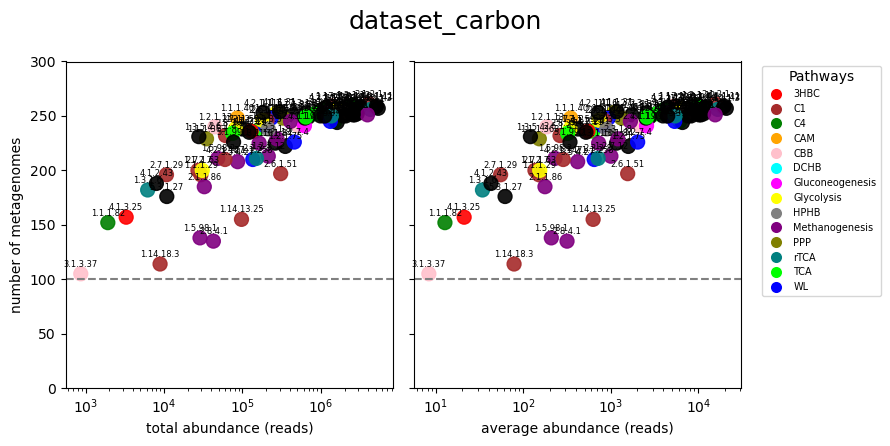

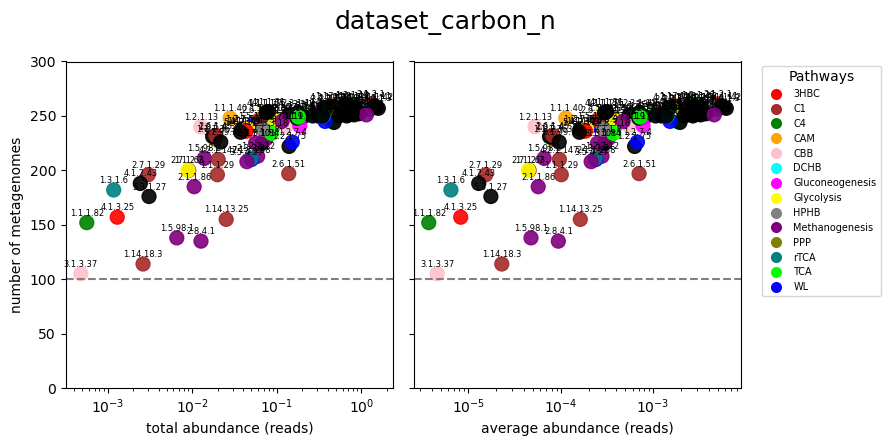

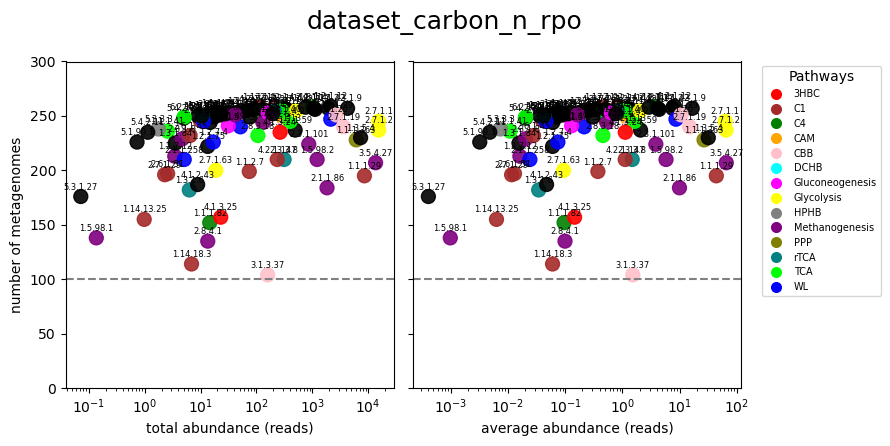

In [215]:
dataset_names = ['dataset_carbon', 'dataset_carbon_n', 'dataset_carbon_n_rpo']

# Loop through the datasets along with their names
for tested_df, dataset_name in zip([dataset_carbon, dataset_carbon_n, dataset_carbon_n_rpo], dataset_names):

    # Calculate prevalence
    prevalence = (tested_df > 0).sum(axis=1)

    # Calculate average and sum of abundances
    filtered_ecdata = tested_df[tested_df > 0]
    average_abundance = filtered_ecdata.sum(axis=1) / filtered_ecdata.count(axis=1)
    sum_abundance = filtered_ecdata.sum(axis=1)

    # Define a specific color for each pathway
    pathway_colors = {
        '3HBC': 'red',
        'C1': 'brown',
        'C4': 'green',
        'CAM': 'orange',
        'CBB': 'pink',
        'DCHB': 'cyan',
        'Gluconeogenesis': 'magenta',
        'Glycolysis': 'yellow',
        'HPHB': 'gray',
        'Methanogenesis': 'purple',
        'PPP': 'olive',
        'rTCA': 'teal',
        'TCA': 'lime',
        'WL': 'blue'
    }

    # Create a dictionary to map EC numbers to colors
    ec_to_pathway = pathways_df.groupby('EC')['pathway'].apply(lambda x: '/'.join(x))
    ec_to_color = {ec: 'black' if len(pathways.split('/')) > 1 else pathway_colors.get(pathways.split('/')[0], 'black')
                for ec, pathways in ec_to_pathway.items()}

    # Map EC numbers to colors
    colors = [ec_to_color.get(ec, 'black') for ec in tested_df.index]

    # Create the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4.5))

    # Plot 1: Average abundance
    scatter1 = ax1.scatter(sum_abundance, prevalence, c=colors, alpha=.9, s=100)
    ax1.axhline(y=100, color='gray', linestyle='--')
    ax1.set_xlabel('total abundance (reads)')
    ax1.set_xscale('log')
    ax1.set_ylabel('number of metagenomes')

    # Plot 2: Sum of abundances
    scatter2 = ax2.scatter(average_abundance, prevalence, c=colors, alpha=.9, s=100)
    ax2.axhline(y=100, color='gray', linestyle='--')
    ax2.set_xlabel('average abundance (reads)')
    ax2.set_xscale('log')
    ax2.set_yticklabels([])
    #ax2.set_ylabel('number of metagenomes')
    ax1.set_ylim(0, 300)
    ax2.set_ylim(0, 300)

    # Add legend to the second plot
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=9, linestyle='') 
            for color in pathway_colors.values()]
    ax2.legend(handles, pathway_colors.keys(), title='Pathways', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7)

    # Annotate dots with EC numbers on both plots
    for i, (x, y, ec) in enumerate(zip(sum_abundance, prevalence, tested_df.index)):
        ax1.annotate(ec, (x, y), textcoords="offset points", xytext=(0,5), ha='center', fontsize=6)

    for i, (x, y, ec) in enumerate(zip(average_abundance, prevalence, tested_df.index)):
        ax2.annotate(ec, (x, y), textcoords="offset points", xytext=(0,5), ha='center', fontsize=6)
    
    fig.suptitle(f"{dataset_name}", fontsize=18)

    plt.tight_layout()
    plt.show()


Prepare the matrix

In [216]:
dataset_complete = dataset_carbon_n #.dropna(axis=1, how='any') #because we have some missing data
#dataset_complete.index.name = None


correlation_matrix = dataset_complete.T.corr(method='spearman')
correlation_matrix[correlation_matrix < 0.5] = 0

Plot with igraph

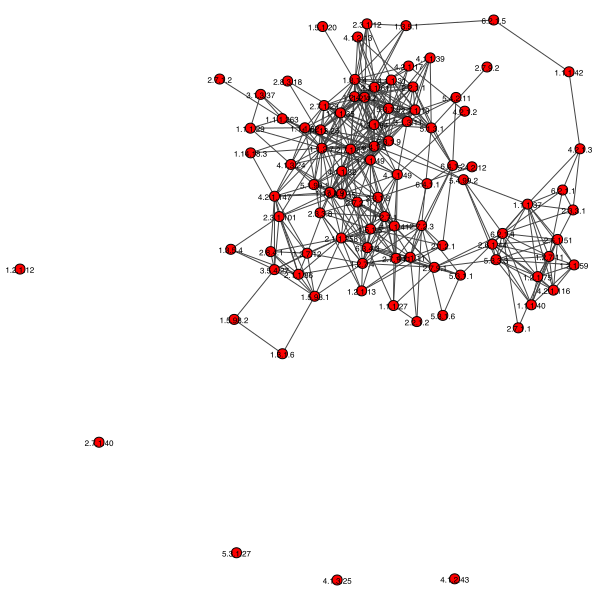

In [217]:
# Create the graph from the matrix
bac_cor_ig = ig.Graph.Adjacency((correlation_matrix.values > 0).tolist(), mode="undirected")
bac_cor_ig.es['weight'] = correlation_matrix.values[correlation_matrix.values > 0]

# Simplify the graph to remove loops and multiple edges
bac_cor_ig = bac_cor_ig.simplify()

# Plot the graph
random.seed(200)
#layout = bac_cor_ig.layout_sugiyama()
layout = bac_cor_ig.layout_kamada_kawai() #g spring embedded
#layout = bac_cor_ig.layout_reingold_tilford()
ig.plot(bac_cor_ig, layout=layout, vertex_size=10, bbox=(600, 600), vertex_label=correlation_matrix.index, vertex_label_size=8, target="graph_plot.pdf")
#ig.plot(bac_cor_ig, vertex_size=10, bbox=(600, 600), vertex_label=correlation_matrix.index, vertex_label_size=8, target="graph_plot.pdf")


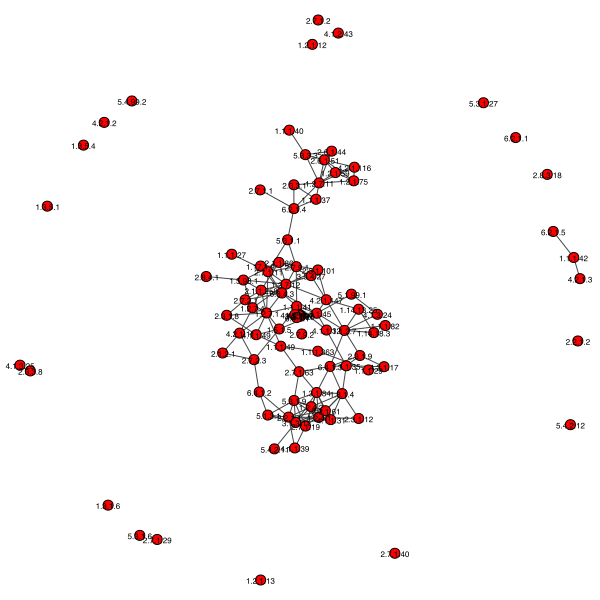

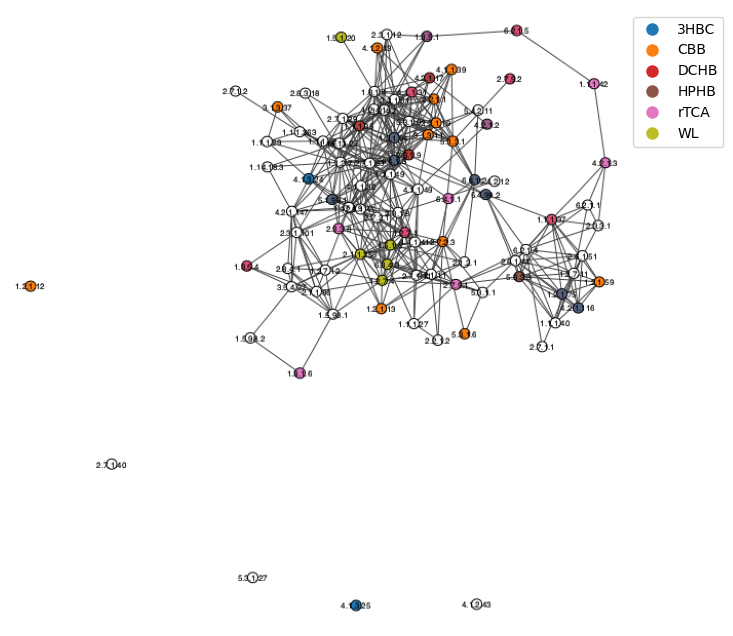

In [218]:

# Create a dictionary mapping EC numbers to pathways
ec_to_pathways = ec_c_fixation_df.groupby('EC')['pathway'].apply(list).to_dict()

# Define the list of possible pathways
#possible_pathways = ['3HBC', 'C1', 'C4', 'CAM', 'CBB', 'DCHB', 'Gluconeogenesis',
 #                    'Glycolysis', 'HPHB', 'InrTCA', 'Methanogenesis', 'PPP', 'rTCA',
 #                    'TCA', 'WL']
possible_pathways = ['3HBC', 'CBB', 'DCHB', 'HPHB', 'rTCA', 'WL']

# Use a specific colormap for distinct colors
cmap = plt.get_cmap('tab10')
color_map = {pathway: cmap(i / len(possible_pathways)) for i, pathway in enumerate(possible_pathways)}


# Function to mix colors if an EC number is associated with multiple pathways
def mix_colors(colors):
    return tuple(sum(x) / len(x) for x in zip(*colors))

# Assign colors to vertices based on their associated pathways
vertex_colors = []
for ec in correlation_matrix.index:
    if ec in ec_to_pathways:
        pathways = ec_to_pathways[ec]
        if len(pathways) > 1:
            mixed_color = mix_colors([color_map[path] for path in pathways])
            vertex_colors.append(mcolors.to_hex(mixed_color))
        else:
            vertex_colors.append(mcolors.to_hex(color_map[pathways[0]]))
    else:
        vertex_colors.append("white")  # Default to black if no pathway is found

# Set the vertex colors
bac_cor_ig.vs['color'] = vertex_colors

random.seed(2)
# Plot using the explicit layout
ig.plot(
    bac_cor_ig, 
    layout=layout, 
    vertex_size=10, 
    bbox=(600, 600), 
    vertex_label=correlation_matrix.index, 
    vertex_label_size=8, 
    target="/tmp/graph_plot.png"  # Save plot to this path
)

# Load the graph plot image
graph_img = Image.open("/tmp/graph_plot.png")

# Plot the graph image and the legend together
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(graph_img)
ax.axis('off')  # Turn off the axis

# Create a legend using matplotlib
legend_elements = [Line2D([0], [0], marker='o', color='w', label=pathway, 
                          markerfacecolor=mcolors.to_hex(color_map[pathway]), markersize=10)
                   for pathway in possible_pathways]

# Add the legend
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1))

#plt.savefig("graph_with_legend.pdf", format="pdf")

plt.show()


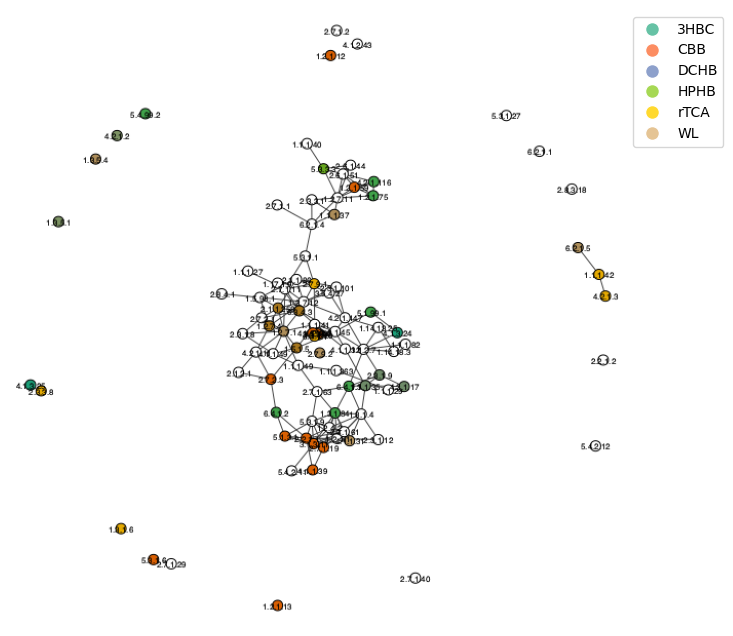

Plot without igraph (weird)

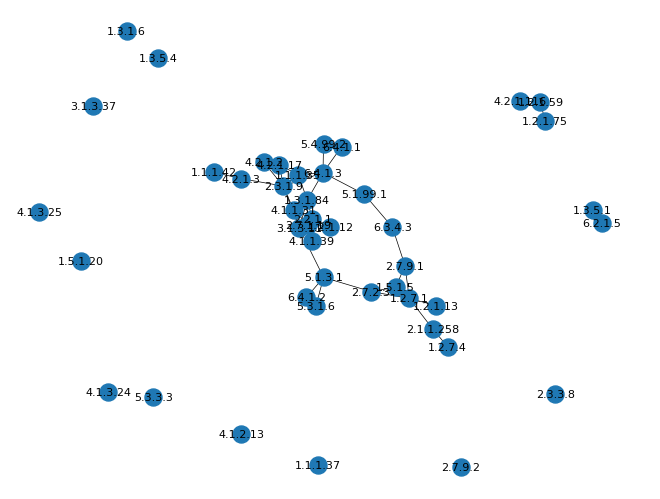

In [167]:

np.fill_diagonal(correlation_matrix.values, 0) # to remove self-loops


labels = {i: correlation_matrix.index[i] for i in range(len(correlation_matrix.index))}


G = nx.from_numpy_array(correlation_matrix.values, create_using=nx.Graph)



pos = nx.spring_layout(G, seed=200)  #, k=0.15, iterations=50)

nx.draw(G, pos, labels=labels, with_labels=labels, node_size=150, width=0.5, font_size=8)

plt.show()


Network statistics

In [26]:
num_edges = bac_cor_ig.ecount()
num_nodes = bac_cor_ig.vcount()
assortativity = bac_cor_ig.assortativity_degree()

print(f"Number of edges: {num_edges}")
print(f"Number of nodes: {num_nodes}")
print(f"Assortativity coefficient: {assortativity}")

Number of edges: 241
Number of nodes: 52
Assortativity coefficient: 0.3351588916478428


In [20]:
num_edges = G.number_of_edges()
num_nodes = G.number_of_nodes()
assortativity = nx.degree_assortativity_coefficient(G)

print(f'Number of edges: {num_edges}')
print(f'Number of nodes: {num_nodes}')
print(f'Assortativity coefficient: {assortativity}')

Number of edges: 241
Number of nodes: 52
Assortativity coefficient: 0.33515889164784257


Identify cliques using Louvain

Modularity: 0.4543212766724136


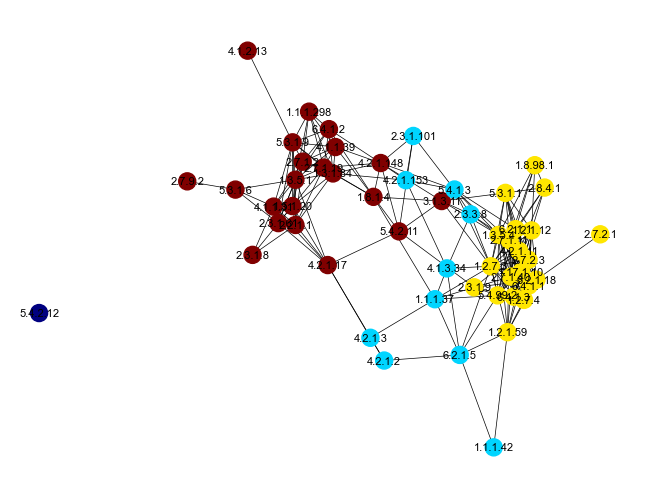

In [385]:
partition = community_louvain.best_partition(G)
modularity = community_louvain.modularity(partition, G)
print(f'Modularity: {modularity}')

# Add color based on community
colors = [partition[node] for node in G.nodes()]

# plot
pos = nx.spring_layout(G, seed=200)  # positions for all nodes

nx.draw(G, pos, node_color=colors, with_labels=True, labels=labels, node_size=150, width=0.5, font_size=8, cmap=plt.cm.jet)
plt.show()

0.4665295019025155


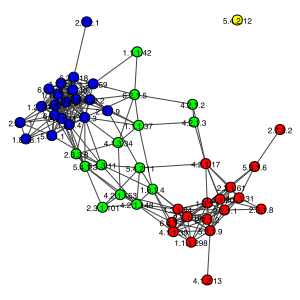

In [35]:
louvain_communities = bac_cor_ig.community_multilevel()

# Modularity
modularity_score = louvain_communities.modularity
print(modularity_score)

# Set vertex colors based on membership
bac_cor_ig.vs['color'] = louvain_communities.membership
palette = ig.drawing.colors.ClusterColoringPalette(len(set(bac_cor_ig.vs['color'])))
colors = [palette[c] for c in bac_cor_ig.vs['color']]

random.seed(28)
ig.plot(bac_cor_ig, vertex_color=colors, vertex_size=10, bbox=(300,300), vertex_label=cor_matrix.index, vertex_label_size=8)



Identify cliques using Greedy clustering

Modularity: 0.4241028177413346


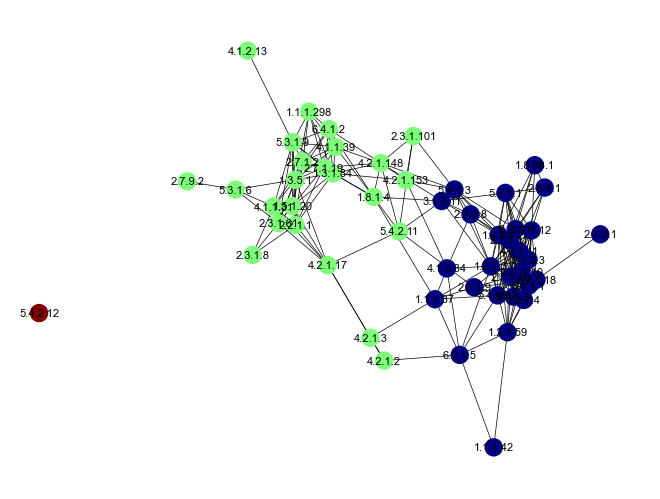

In [384]:
greedy_communities = community.greedy_modularity_communities(G)
greedy_partition = {node: i for i, comm in enumerate(greedy_communities) for node in comm}
modularity = community.modularity(G, greedy_communities)
print(f'Modularity: {modularity}')

# Add color based on community
colors = [greedy_partition[node] for node in G.nodes()]

# plot
pos = nx.spring_layout(G, seed=200)  # positions for all nodes

nx.draw(G, pos, node_color=colors, with_labels=labels, labels=labels, width=0.5, node_size=150, font_size=8, cmap=plt.cm.jet)
#nx.draw(G, pos, labels=labels, with_labels=labels, node_size=150, width=0.5, font_size=8)

#plt.savefig("carbon_greedy_network_cliques.svg", format='svg')
plt.show()

0.41909574559666674


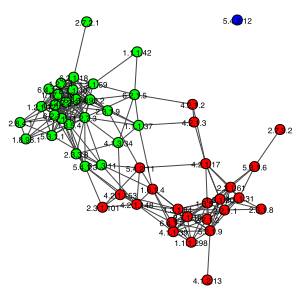

In [40]:

# Identify cliques using Greedy clustering
dendrogram = bac_cor_ig.community_fastgreedy()
greedy_communities = dendrogram.as_clustering()

# Modularity
modularity_score = greedy_communities.modularity
print(modularity_score)

# Set vertex colors based on membership
bac_cor_ig.vs['color'] = greedy_communities.membership
palette = ig.drawing.colors.ClusterColoringPalette(len(set(bac_cor_ig.vs['color'])))
colors = [palette[c] for c in bac_cor_ig.vs['color']]

# Plot the graph
random.seed(28)
ig.plot(bac_cor_ig, vertex_color=colors, vertex_size=10, bbox=(300,300), vertex_label=cor_matrix.index, vertex_label_size=8)



Modularity: 0.4175634028339732


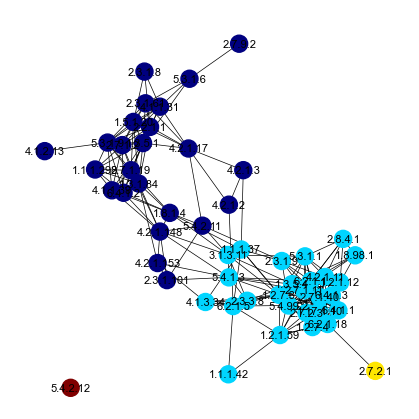

In [398]:

# Convert NetworkX graph to igraph graph
G_igraph = ig.Graph.from_networkx(G)

# Identify communities using Fast Greedy clustering
fast_greedy = G_igraph.community_fastgreedy()
# Get the community structure at the desired level
# The number of clusters (k) is chosen. Adjust as needed.
k = 4  # Number of desired communities (adjust as needed)
communities = fast_greedy.as_clustering(k)

# Compute modularity
modularity = G_igraph.modularity(communities)
print(f'Modularity: {modularity}')

# Map communities to colors
membership = communities.membership
colors = [membership[node] for node in G_igraph.vs.indices]

# Convert igraph layout to NetworkX format
layout = G_igraph.layout("fr")  # Fruchterman-Reingold layout

# Convert layout from igraph to NetworkX format
pos = {i: (layout[i][0], layout[i][1]) for i in range(len(layout))}

# Draw the graph using NetworkX with igraph layout
plt.figure(figsize=(4, 4))

nx.draw(G, pos, node_color=colors, with_labels=labels, labels=labels, width=0.5, node_size=150, font_size=8, cmap=plt.cm.jet)
#plt.savefig("carbon_network_cliques.svg", format='svg')
plt.show()


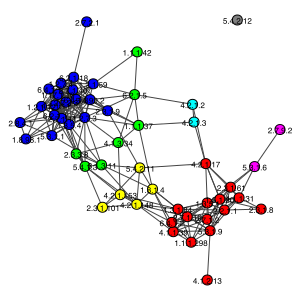

In [41]:
# Identify cliques using Walktrap
walktrap_communities = bac_cor_ig.community_walktrap().as_clustering()

# Modularity
modularity_score = walktrap_communities.modularity

# Set vertex colors based on membership
bac_cor_ig.vs['color'] = walktrap_communities.membership
palette = ig.drawing.colors.ClusterColoringPalette(len(set(bac_cor_ig.vs['color'])))
colors = [palette[c] for c in bac_cor_ig.vs['color']]

# Plot the graph
random.seed(28)
ig.plot(bac_cor_ig, vertex_color=colors, vertex_size=10, bbox=(300,300), vertex_label=cor_matrix.index, vertex_label_size=8)

In [42]:
louvain_sizes = louvain_communities.sizes()
greedy_sizes = greedy_communities.sizes()
walktrap_sizes = walktrap_communities.sizes()

print("Louvain community sizes:", louvain_sizes)
print("Greedy community sizes:", greedy_sizes)
print("Walktrap community sizes:", walktrap_sizes)

Louvain community sizes: [17, 14, 20, 1]
Greedy community sizes: [24, 27, 1]
Walktrap community sizes: [15, 7, 20, 5, 2, 2, 1]


## Testing Louvain cliques against the environmental parameters

In [139]:
#clique 1: CBB
#clique 2: rTCA
#clique 3: WL
#clique 4: PGM (glycolysis)

In [48]:
# Assigning cor_matrix.index as the ASV identifiers for the vertices
bac_cor_ig.vs['ASV_id'] = cor_matrix.index

# Extracting the list of ASVs for the main cliques identified by the Louvain function
bac_cor_group1 = [v['ASV_id'] for v in bac_cor_ig.vs if louvain_communities.membership[v.index] == 0]
bac_cor_group2 = [v['ASV_id'] for v in bac_cor_ig.vs if louvain_communities.membership[v.index] == 1]
bac_cor_group3 = [v['ASV_id'] for v in bac_cor_ig.vs if louvain_communities.membership[v.index] == 2]
bac_cor_group4 = [v['ASV_id'] for v in bac_cor_ig.vs if louvain_communities.membership[v.index] == 3]

# Print the lists of ASVs
print("Group 1 ASVs :", bac_cor_group1)
print("Group 2 ASVs:", bac_cor_group2)
print("Group 3 ASVs:", bac_cor_group3)
print("Group 4 ASVs:", bac_cor_group4)


Group 1 ASVs: ['1.1.1.298', '1.3.1.84', '1.3.5.1', '1.5.1.20', '2.2.1.1', '2.3.1.61', '2.3.1.8', '2.7.1.19', '2.7.1.2', '2.7.9.2', '4.1.1.31', '4.1.1.39', '4.1.2.13', '4.2.1.17', '5.3.1.6', '5.3.1.9', '6.4.1.2']
Group 2 ASVs: ['1.1.1.37', '1.1.1.42', '1.8.1.4', '2.3.1.101', '2.3.3.8', '3.1.3.11', '4.1.3.34', '4.2.1.148', '4.2.1.153', '4.2.1.2', '4.2.1.3', '5.4.1.3', '5.4.2.11', '6.2.1.5']
Group 3 ASVs: ['1.17.1.10', '1.2.1.12', '1.2.1.59', '1.2.7.3', '1.2.7.4', '1.3.5.4', '1.8.98.1', '2.3.1.9', '2.7.1.11', '2.7.1.40', '2.7.2.1', '2.7.2.3', '2.8.4.1', '4.2.1.11', '5.3.1.1', '5.4.99.2', '6.2.1.1', '6.2.1.18', '6.4.1.1', '6.4.1.3']
Group 4 ASVs: ['5.4.2.12']


subsetting cliques

In [50]:
clique1 = dataset_carbon.loc[dataset_carbon.index.isin(bac_cor_group1)]
clique2 = dataset_carbon.loc[dataset_carbon.index.isin(bac_cor_group2)]
clique3 = dataset_carbon.loc[dataset_carbon.index.isin(bac_cor_group3)]
clique4 = dataset_carbon.loc[dataset_carbon.index.isin(bac_cor_group4)]

col_sums_clique1 = clique1.sum(axis=0)
col_sums_clique2 = clique2.sum(axis=0)
col_sums_clique3 = clique3.sum(axis=0)
col_sums_clique4 = clique4.sum(axis=0)

In [187]:
print(col_sums_clique1.index.tolist())
print(col_sums_clique2.index.tolist())
print(col_sums_clique3.index.tolist())
print(col_sums_clique4.index.tolist())

['BQF', 'BQS', 'BQS1', 'BR1F', 'BRF1', 'BRF2', 'BRS1', 'BRS2', 'CYF', 'CYS', 'EPF', 'EPS', 'ESF9', 'ETS', 'FAS', 'MTF', 'PBS', 'QH2F', 'QHS1', 'QHS2', 'QNF', 'QNS', 'RSF', 'RSS', 'RVF', 'SIF', 'SIS', 'SLF', 'SLS', 'TCF', 'TCS']
['BQF', 'BQS', 'BQS1', 'BR1F', 'BRF1', 'BRF2', 'BRS1', 'BRS2', 'CYF', 'CYS', 'EPF', 'EPS', 'ESF9', 'ETS', 'FAS', 'MTF', 'PBS', 'QH2F', 'QHS1', 'QHS2', 'QNF', 'QNS', 'RSF', 'RSS', 'RVF', 'SIF', 'SIS', 'SLF', 'SLS', 'TCF', 'TCS']
['BQF', 'BQS', 'BQS1', 'BR1F', 'BRF1', 'BRF2', 'BRS1', 'BRS2', 'CYF', 'CYS', 'EPF', 'EPS', 'ESF9', 'ETS', 'FAS', 'MTF', 'PBS', 'QH2F', 'QHS1', 'QHS2', 'QNF', 'QNS', 'RSF', 'RSS', 'RVF', 'SIF', 'SIS', 'SLF', 'SLS', 'TCF', 'TCS']
['BQF', 'BQS', 'BQS1', 'BR1F', 'BRF1', 'BRF2', 'BRS1', 'BRS2', 'CYF', 'CYS', 'EPF', 'EPS', 'ESF9', 'ETS', 'FAS', 'MTF', 'PBS', 'QH2F', 'QHS1', 'QHS2', 'QNF', 'QNS', 'RSF', 'RSS', 'RVF', 'SIF', 'SIS', 'SLF', 'SLS', 'TCF', 'TCS']


In [220]:
# Load the environmental data
envdata = pd.read_csv("subductCR_final_dataset.csv", index_col="code")

print(envdata.index.tolist())


FileNotFoundError: [Errno 2] No such file or directory: 'subductCR_final_dataset.csv'

In [189]:
#ADDED BY BENOIT: add the col_sums of each clique in a new col (OK to do so because the indexes match between the envdata dataframe and all the col_sums_clique series)
envdata["sums_clique1"] = col_sums_clique1.values
envdata["sums_clique2"] = col_sums_clique2.values
envdata["sums_clique3"] = col_sums_clique3.values
envdata["sums_clique4"] = col_sums_clique4.values

test: plot clique X against dic

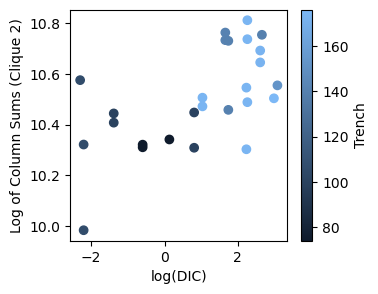

Spearman correlation coefficient (rho): 0.5845483060289691
P-value: 0.0017126087498798804


In [190]:
plt.figure(figsize=(3.5, 3))  

cmap = mcolors.LinearSegmentedColormap.from_list(
    'custom_blues',
    ['#0f1b2cff', '#7cb8f6ff']
)

# Scatter plot with color based on 'trench'
scatter = plt.scatter(np.log(envdata['dic']), np.log(envdata['sums_clique2']), c=envdata['trench'], cmap=cmap)


# Add colorbar
plt.colorbar(scatter, label='Trench')

#plt.xscale('log')
plt.xlabel('log(DIC)')
plt.ylabel('Log of Column Sums (Clique 2)')
plt.show()

# Calculate Spearman correlation
rho, p_value = spearmanr(np.log(clean_data['dic']), np.log(clean_data['sums_clique2']))

print(f"Spearman correlation coefficient (rho): {rho}")
print(f"P-value: {p_value}")

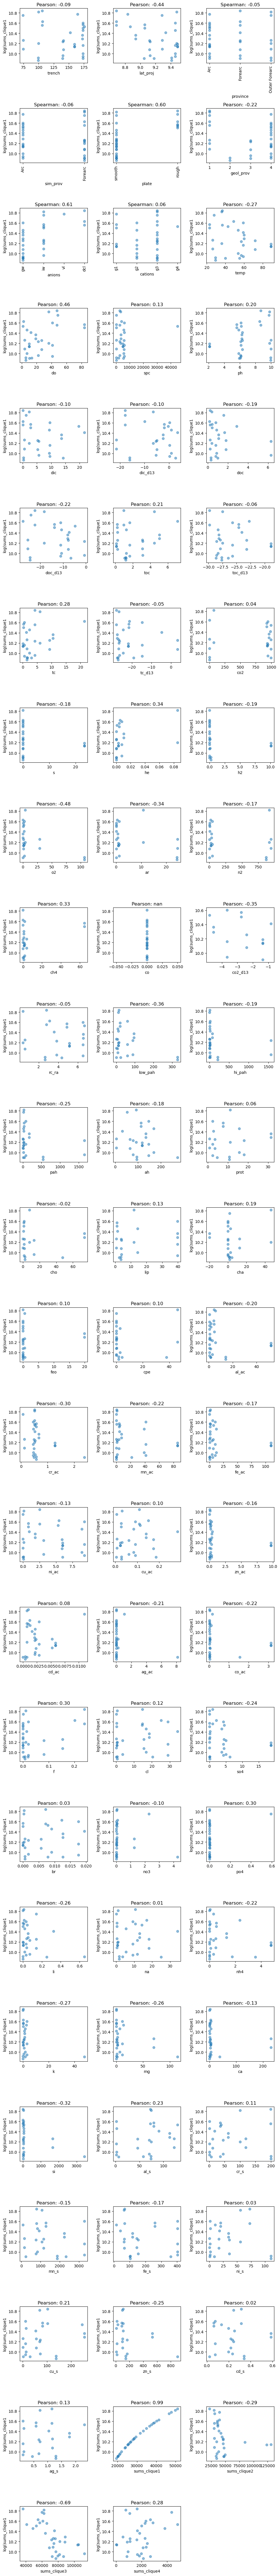

In [135]:
clique = 'clique1'

# Number of rows needed
n_rows = int(np.ceil(len(envdata.columns) / 3))

# Create subplots
fig, axes = plt.subplots(n_rows, 3, figsize=(10, 3.5 * n_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each column against the log of sums_clique
for i, column in enumerate(envdata.columns):
    ax = axes[i]
    
    # Check if the column is numeric or categorical
    if pd.api.types.is_numeric_dtype(envdata[column]):
        # Drop NaN values
        valid_data = envdata.dropna(subset=[column, f'sums_{clique}'])
        x = valid_data[column]
        y = np.log(valid_data[f'sums_{clique}'])
        
        # Plot numeric columns
        ax.scatter(x, y, alpha=0.5)
        ax.set_xlabel(column)
        ax.set_ylabel(f'log(sums_{clique}')
        
        # Calculate and display Pearson correlation coefficient
        corr, _ = pearsonr(x, y)
        ax.set_title(f'Pearson: {corr:.2f}')
    else:
        # Drop NaN values
        valid_data = envdata.dropna(subset=[column, f'sums_{clique}'])
        x = valid_data[column]
        y = np.log(valid_data[f'sums_{clique}'])
        
        unique_categories = x.dropna().unique()
        category_map = {category: idx for idx, category in enumerate(unique_categories)}
        numeric_categories = x.map(category_map)
        
        # Plot categorical columns
        ax.scatter(numeric_categories, y, alpha=0.5)
        ax.set_xlabel(column)
        ax.set_ylabel(f'log(sums_{clique}')
        ax.set_xticks(range(len(unique_categories)))
        ax.set_xticklabels(unique_categories, rotation=90)
        
        # Calculate and display Spearman correlation coefficient
        corr, _ = spearmanr(numeric_categories, y)
        ax.set_title(f'Spearman: {corr:.2f}')

# Turn off any unused subplots
for j in range(len(envdata.columns), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


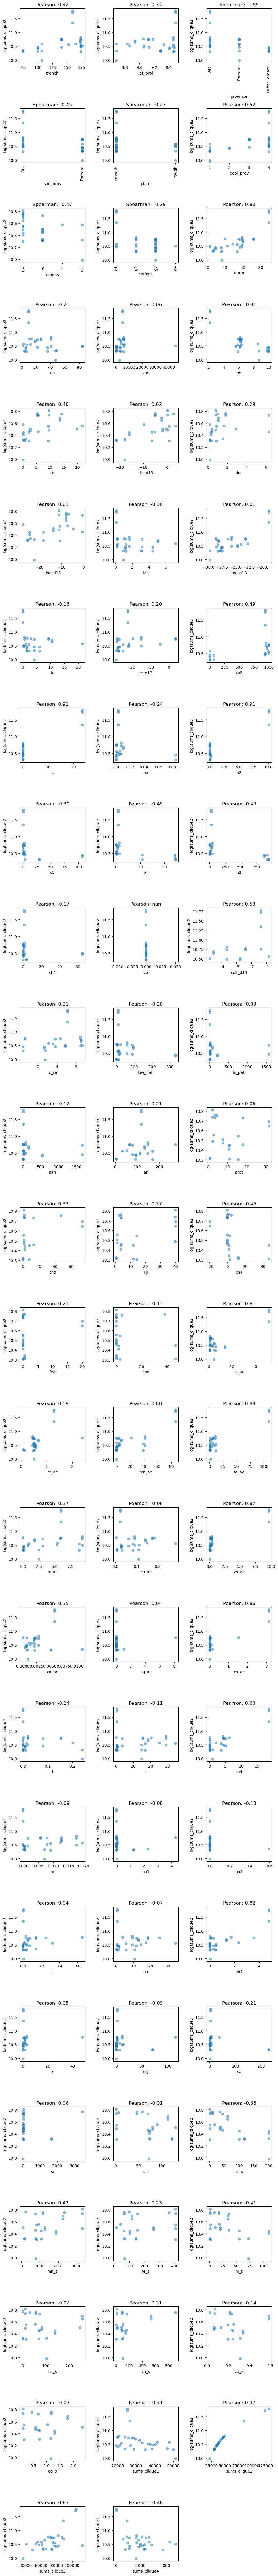

In [136]:
clique = 'clique2'

# Number of rows needed
n_rows = int(np.ceil(len(envdata.columns) / 3))

# Create subplots
fig, axes = plt.subplots(n_rows, 3, figsize=(10, 3.5 * n_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each column against the log of sums_clique
for i, column in enumerate(envdata.columns):
    ax = axes[i]
    
    # Check if the column is numeric or categorical
    if pd.api.types.is_numeric_dtype(envdata[column]):
        # Drop NaN values
        valid_data = envdata.dropna(subset=[column, f'sums_{clique}'])
        x = valid_data[column]
        y = np.log(valid_data[f'sums_{clique}'])
        
        # Plot numeric columns
        ax.scatter(x, y, alpha=0.5)
        ax.set_xlabel(column)
        ax.set_ylabel(f'log(sums_{clique}')
        
        # Calculate and display Pearson correlation coefficient
        corr, _ = pearsonr(x, y)
        ax.set_title(f'Pearson: {corr:.2f}')
    else:
        # Drop NaN values
        valid_data = envdata.dropna(subset=[column, f'sums_{clique}'])
        x = valid_data[column]
        y = np.log(valid_data[f'sums_{clique}'])
        
        unique_categories = x.dropna().unique()
        category_map = {category: idx for idx, category in enumerate(unique_categories)}
        numeric_categories = x.map(category_map)
        
        # Plot categorical columns
        ax.scatter(numeric_categories, y, alpha=0.5)
        ax.set_xlabel(column)
        ax.set_ylabel(f'log(sums_{clique}')
        ax.set_xticks(range(len(unique_categories)))
        ax.set_xticklabels(unique_categories, rotation=90)
        
        # Calculate and display Spearman correlation coefficient
        corr, _ = spearmanr(numeric_categories, y)
        ax.set_title(f'Spearman: {corr:.2f}')

# Turn off any unused subplots
for j in range(len(envdata.columns), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


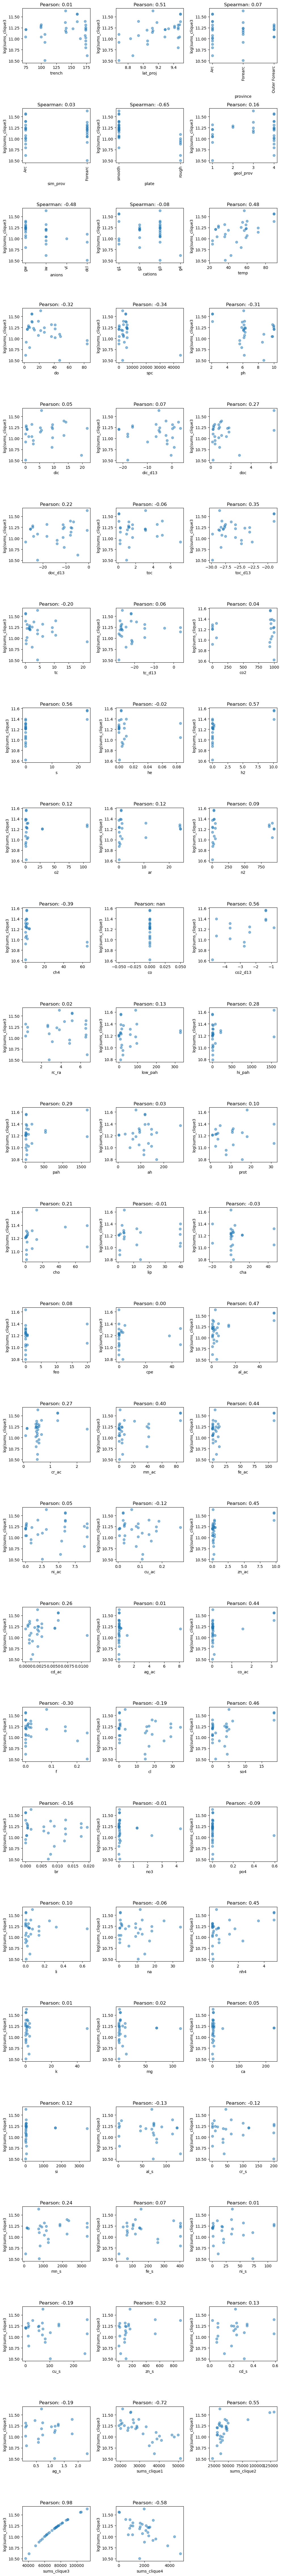

In [137]:
clique = 'clique3'

# Number of rows needed
n_rows = int(np.ceil(len(envdata.columns) / 3))

# Create subplots
fig, axes = plt.subplots(n_rows, 3, figsize=(10, 3.5 * n_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each column against the log of sums_clique
for i, column in enumerate(envdata.columns):
    ax = axes[i]
    
    # Check if the column is numeric or categorical
    if pd.api.types.is_numeric_dtype(envdata[column]):
        # Drop NaN values
        valid_data = envdata.dropna(subset=[column, f'sums_{clique}'])
        x = valid_data[column]
        y = np.log(valid_data[f'sums_{clique}'])
        
        # Plot numeric columns
        ax.scatter(x, y, alpha=0.5)
        ax.set_xlabel(column)
        ax.set_ylabel(f'log(sums_{clique}')
        
        # Calculate and display Pearson correlation coefficient
        corr, _ = pearsonr(x, y)
        ax.set_title(f'Pearson: {corr:.2f}')
    else:
        # Drop NaN values
        valid_data = envdata.dropna(subset=[column, f'sums_{clique}'])
        x = valid_data[column]
        y = np.log(valid_data[f'sums_{clique}'])
        
        unique_categories = x.dropna().unique()
        category_map = {category: idx for idx, category in enumerate(unique_categories)}
        numeric_categories = x.map(category_map)
        
        # Plot categorical columns
        ax.scatter(numeric_categories, y, alpha=0.5)
        ax.set_xlabel(column)
        ax.set_ylabel(f'log(sums_{clique}')
        ax.set_xticks(range(len(unique_categories)))
        ax.set_xticklabels(unique_categories, rotation=90)
        
        # Calculate and display Spearman correlation coefficient
        corr, _ = spearmanr(numeric_categories, y)
        ax.set_title(f'Spearman: {corr:.2f}')

# Turn off any unused subplots
for j in range(len(envdata.columns), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


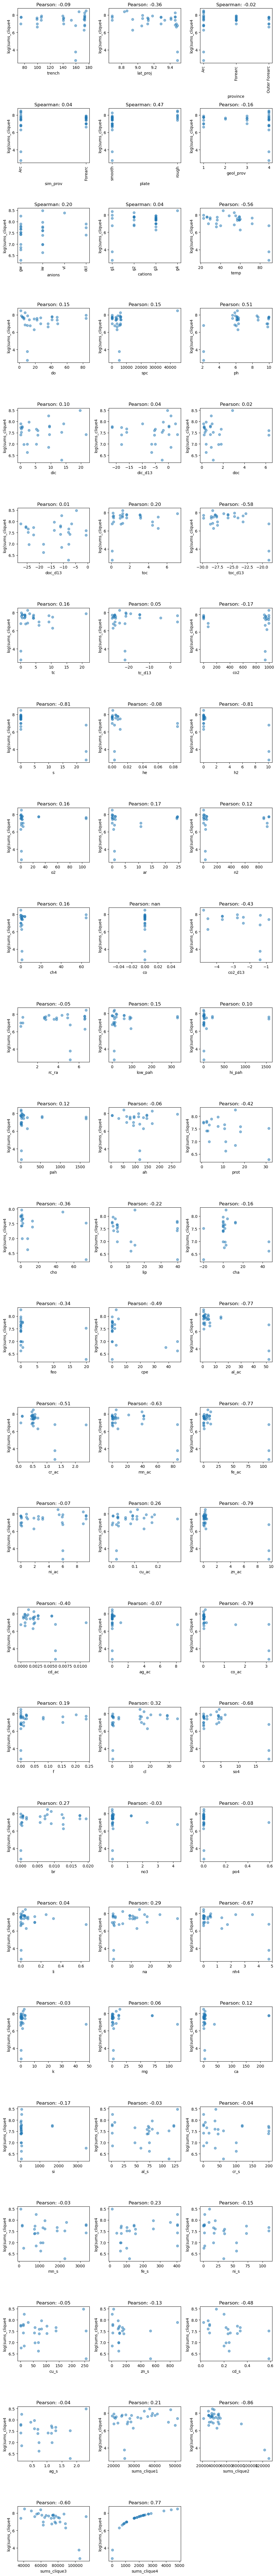

In [138]:
clique = 'clique4'

# Number of rows needed
n_rows = int(np.ceil(len(envdata.columns) / 3))

# Create subplots
fig, axes = plt.subplots(n_rows, 3, figsize=(10, 3.5 * n_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each column against the log of sums_clique
for i, column in enumerate(envdata.columns):
    ax = axes[i]
    
    # Check if the column is numeric or categorical
    if pd.api.types.is_numeric_dtype(envdata[column]):
        # Drop NaN values
        valid_data = envdata.dropna(subset=[column, f'sums_{clique}'])
        x = valid_data[column]
        y = np.log(valid_data[f'sums_{clique}'])
        
        # Plot numeric columns
        ax.scatter(x, y, alpha=0.5)
        ax.set_xlabel(column)
        ax.set_ylabel(f'log(sums_{clique}')
        
        # Calculate and display Pearson correlation coefficient
        corr, _ = pearsonr(x, y)
        ax.set_title(f'Pearson: {corr:.2f}')
    else:
        # Drop NaN values
        valid_data = envdata.dropna(subset=[column, f'sums_{clique}'])
        x = valid_data[column]
        y = np.log(valid_data[f'sums_{clique}'])
        
        unique_categories = x.dropna().unique()
        category_map = {category: idx for idx, category in enumerate(unique_categories)}
        numeric_categories = x.map(category_map)
        
        # Plot categorical columns
        ax.scatter(numeric_categories, y, alpha=0.5)
        ax.set_xlabel(column)
        ax.set_ylabel(f'log(sums_{clique}')
        ax.set_xticks(range(len(unique_categories)))
        ax.set_xticklabels(unique_categories, rotation=90)
        
        # Calculate and display Spearman correlation coefficient
        corr, _ = spearmanr(numeric_categories, y)
        ax.set_title(f'Spearman: {corr:.2f}')

# Turn off any unused subplots
for j in range(len(envdata.columns), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()
